# Import Libs

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import glob

# Reading functions

In [25]:

def rainrate_zr(Z_dBZ, a=200, b=1.6):
    """Calculate rain Z-R ."""
    rr = (10 ** (Z_dBZ / 10.0) / a) ** (1 / b)
    return rr

def read_and_process_ld(ld_path, start_time, end_time):
    """laser disdrometer data."""
    ds = xr.open_mfdataset(ld_path)
    ld_df = ds.precip_rate.to_dataframe().rename(columns={'precip_rate': 'rain_ld'})
    ld_df = ld_df.loc[start_time:end_time]
    return ld_df

def read_and_process_ldq(ldq_path, start_time, end_time):
    """LDQuant data."""
    ds = xr.open_mfdataset(ldq_path)
    ldq_df = ds.rain_rate.to_dataframe().rename(columns={'rain_rate': 'rain_ldq'})
    ldq_df = ldq_df.loc[start_time:end_time]
    return ldq_df

def read_and_process_pl2(pl2_path, start_time, end_time):
    """pluvio data."""
    ds = xr.open_mfdataset(pl2_path)
    pl2_df = ds.intensity_rtnrt.to_dataframe().rename(columns={'intensity_rtnrt': 'rain_pl2'})
    pl2_df = pl2_df.loc[start_time:end_time]
    return pl2_df

def read_and_process_radar(filename):
    """radar data."""
    df = pd.read_csv(filename, parse_dates=True)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df.index = df.index.round('min')
    df['rain_rate_zr'] = rainrate_zr(df['corrected_reflectivity'])
    return df

def merge_dataframes(primary_df, dfs_to_merge):
    """Merge dataframes based on the radar dataframe's index."""
    reindexed_dfs = [df.reindex(primary_df.index) for df in dfs_to_merge]
    merged_df = pd.concat([primary_df] + reindexed_dfs, axis=1)
    return merged_df


# plotting functinos

In [26]:

def plot_pairplot(df, columns, filename=None):
    """pairplot for selected columns."""
    pairplot_fig = sns.pairplot(df[columns].dropna())
    if filename:
        pairplot_fig.savefig(filename)
    plt.show()

def plot_scatter(df, x_col, y_col, title, x_label, y_label, filename=None):
    """scatter plot."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_accumulated_rainfall(df, columns, title, filename=None):
    """Plot accumulated rain comparison."""
    plt.figure(figsize=(14, 8))
    for col in columns:
        plt.plot(df.index, df[col].cumsum(), label=col)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Accumulated Rainfall (mm)')
    plt.legend()
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()
    

def calculate_statistics(df, truth_col, estimate_cols):
    """Calculate stats and compare estimated rain."""
    stats = {}
    for col in estimate_cols:
        bias = (df[col] - df[truth_col]).mean()
        rmse = np.sqrt(((df[col] - df[truth_col]) ** 2).mean())
        correlation = df[[truth_col, col]].corr().iloc[0, 1]
        stats[col] = {'Bias': bias, 'RMSE': rmse, 'Correlation': correlation}
    return pd.DataFrame(stats)

def plot_time_series(df, columns, title, filename=None):
    """Plot ts for selected columns."""
    plt.figure(figsize=(14, 8))
    for col in columns:
        plt.plot(df.index, df[col], label=col)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Rain Rate (mm/h)')
    plt.legend()
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_histogram(df, columns, title, filename=None):
    """Plot hist for the selected columns."""
    plt.figure(figsize=(14, 8))
    for col in columns:
        plt.hist(df[col].dropna(), bins=30, alpha=0.5, label=col, log=True)
    plt.title(title)
    plt.xlabel('Rain Rate (mm/h)')
    plt.ylabel('Frequency')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_scatter_comparison(df, truth_col, estimate_cols, filename_prefix=None):
    """Scatter plots comparing estimated rain with the true rain."""
    for col in estimate_cols:
        plt.figure(figsize=(8, 6))
        plt.scatter(df[truth_col], df[col], alpha=0.5)
        plt.plot([df[truth_col].min(), df[truth_col].max()], [df[truth_col].min(), df[truth_col].max()], 'r--')
        plt.title(f'{col} vs {truth_col}')
        plt.xlabel(f'{truth_col} (mm/h)')
        plt.ylabel(f'{col} (mm/h)')
        plt.grid(True)
        if filename_prefix:
            plt.savefig(f'{filename_prefix}_{col}_vs_{truth_col}.png')
        plt.show()



In [27]:
start_time = '2022-08-01 00'
end_time = '2022-08-31 00'



# Read and process data


In [28]:

ld_path = glob.glob("/Users/bhupendra/projects/sail/data/gucldM1_b1/*.cdf")
ld_df = read_and_process_ld(ld_path, start_time, end_time)

ldq_path = glob.glob("/Users/bhupendra/projects/sail/data/gucldquantsM1_c1/*.nc")
ldq_df = read_and_process_ldq(ldq_path, start_time, end_time)

pl2_path = glob.glob("/Users/bhupendra/projects/sail/data/gucwbpluvio2M1_a1/*.nc")
pl2_df = read_and_process_pl2(pl2_path, start_time, end_time)

radar_filename = '/Users/bhupendra/projects/sail/data/output/radar_data.csv'
radar_df = read_and_process_radar(radar_filename)

# Merge dataframes
dfs_to_merge = [pl2_df, ld_df, ldq_df]
merged_df = merge_dataframes(radar_df, dfs_to_merge)



# Select columns for pairplot


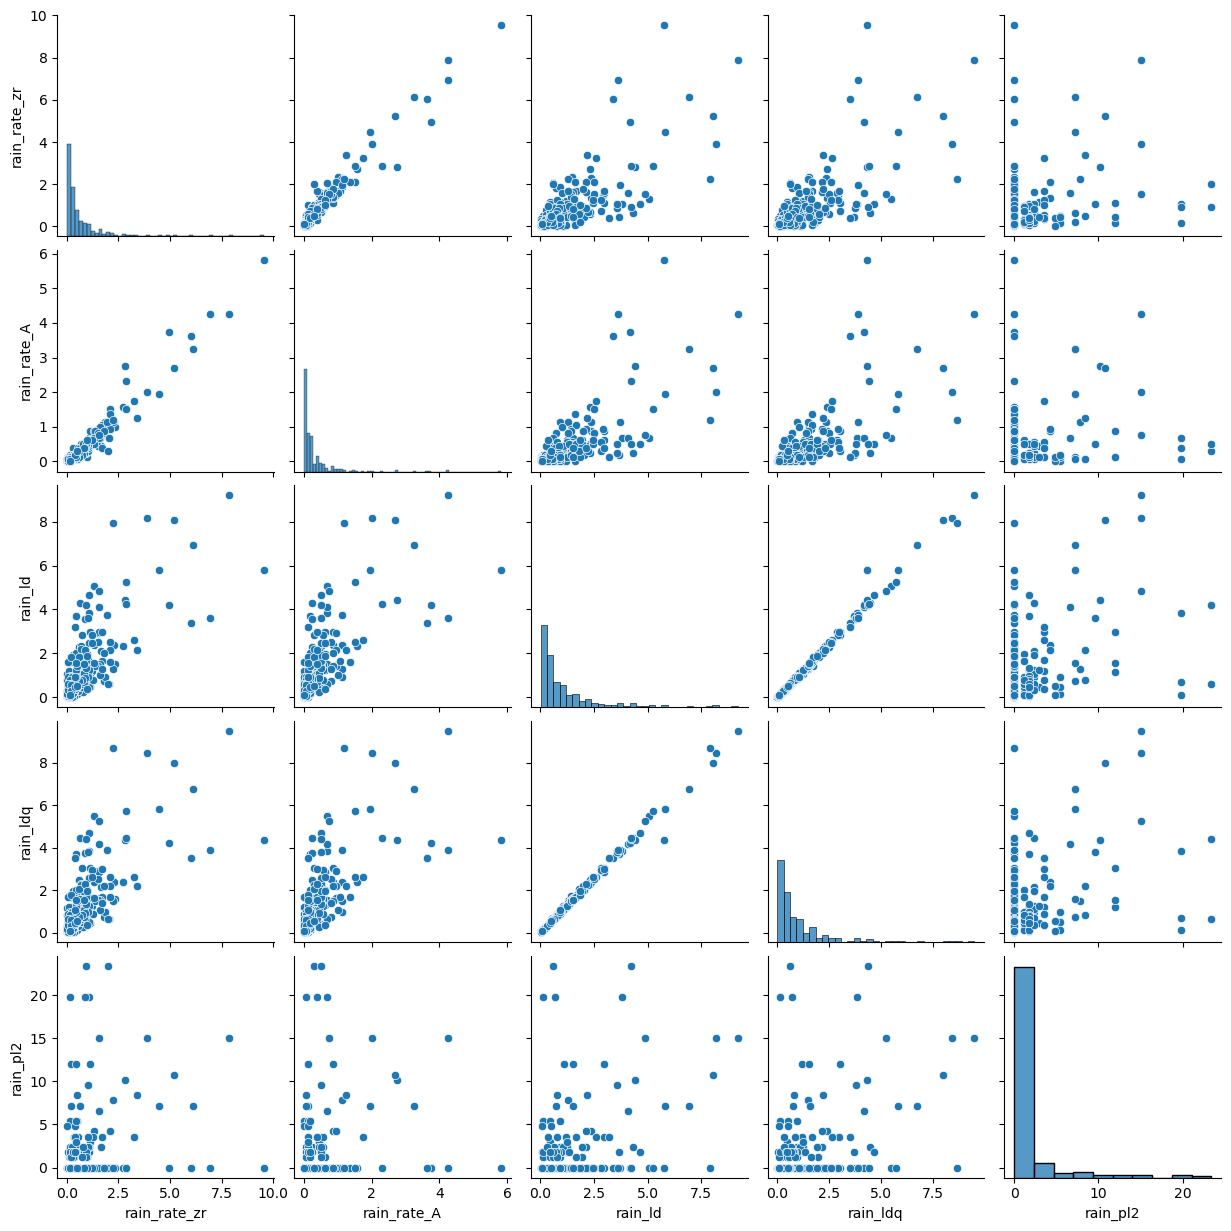

In [29]:

selected_columns = ['rain_rate_zr', 'rain_rate_A', 'rain_ld', 'rain_ldq', 'rain_pl2']
plot_pairplot(merged_df, selected_columns, filename='/Users/bhupendra/projects/sail/data/compare_rain.pdf')


Rain from radar attenuation and ZR relationship matches better and LDQuant and LD matches with each other that being from the same instruments. PL2 matches less with any of the radar or LD products.


# Scatter plot comparison


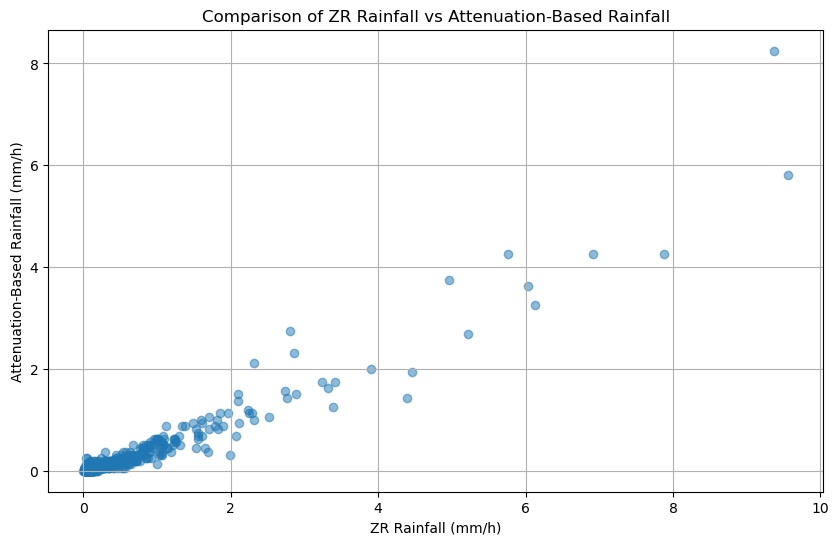

In [30]:

plot_scatter(radar_df, 'rain_rate_zr', 'rain_rate_A', 'Comparison of ZR Rainfall vs Attenuation-Based Rainfall', 'ZR Rainfall (mm/h)', 'Attenuation-Based Rainfall (mm/h)')



# Select a few columns for another pairplot


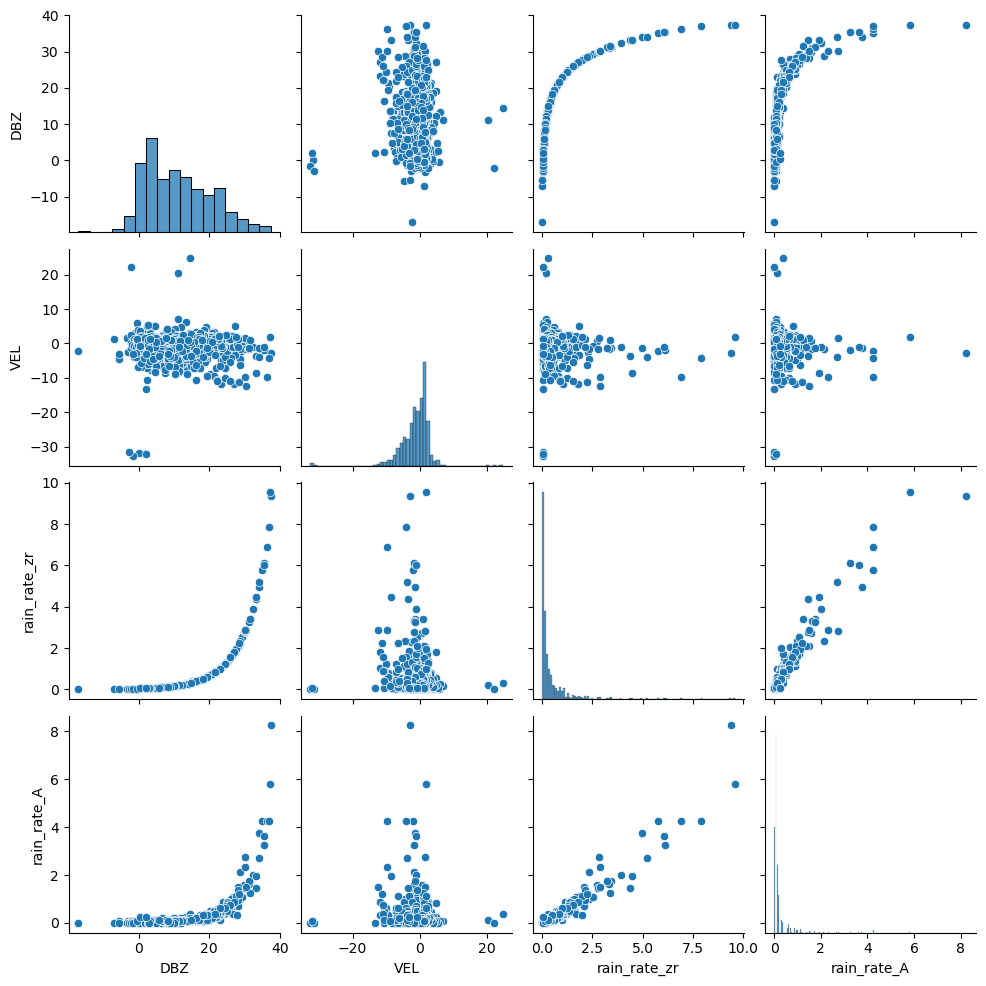

In [31]:

selected_columns = ['DBZ', 'VEL', 'rain_rate_zr', 'rain_rate_A']
plot_pairplot(radar_df, selected_columns, filename='radar-pair_plot.png')



# Plot accumulated rainfall


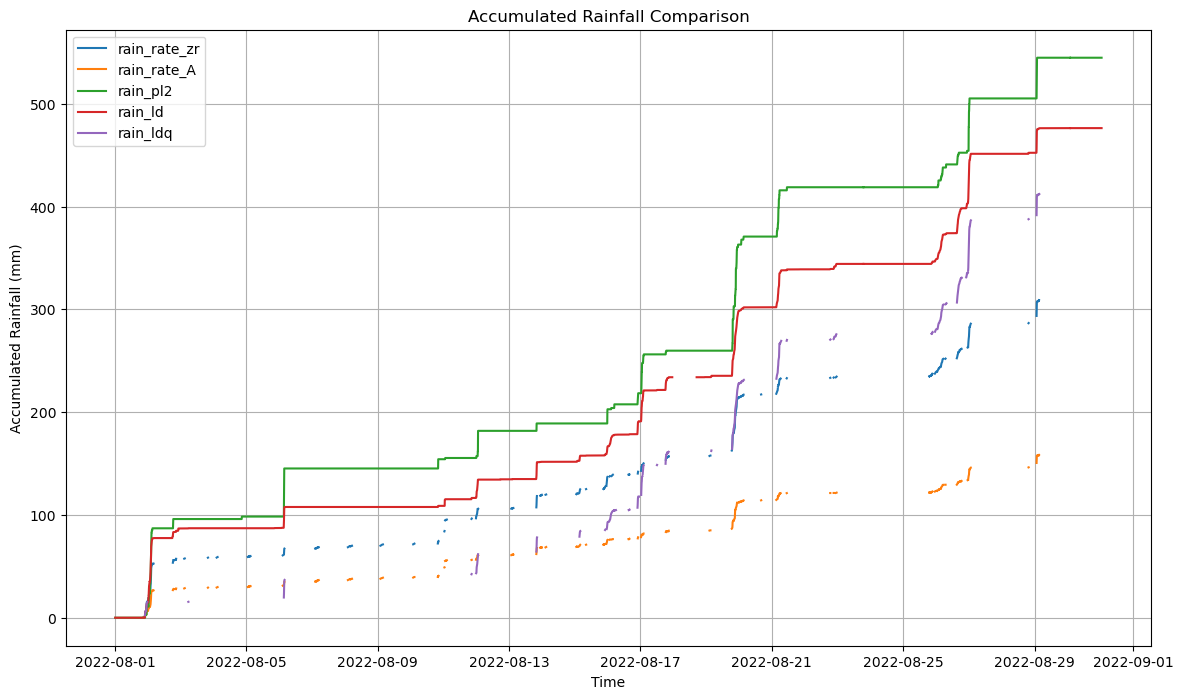

In [32]:

accumulated_columns = ['rain_rate_zr', 'rain_rate_A', 'rain_pl2', 'rain_ld', 'rain_ldq']
plot_accumulated_rainfall(merged_df, accumulated_columns, 'Accumulated Rainfall Comparison')



The NAN in pl2 and LD are causing intermediate lines. I may have to chnage NAN to 0

# Calculate statistics


In [39]:

estimate_cols = ['rain_rate_zr', 'rain_rate_A', 'rain_ldq']
stats_pl2 = calculate_statistics(merged_df, 'rain_pl2', estimate_cols)
stats_ld = calculate_statistics(merged_df, 'rain_ld', estimate_cols)
print("Statistics compared to PL2 (truth):")
print(stats_pl2)
print("\nStatistics compared to LD (truth):")
print(stats_ld)


Statistics compared to PL2 (truth):
             rain_rate_zr  rain_rate_A  rain_ldq
Bias            -0.287418    -0.528818 -0.062430
RMSE             2.593127     2.688474  2.770417
Correlation      0.342107     0.278901  0.435017

Statistics compared to LD (truth):
             rain_rate_zr  rain_rate_A  rain_ldq
Bias            -0.166584    -0.407984  0.028603
RMSE             0.856056     1.026706  0.104237
Correlation      0.734964     0.656379  0.997267


Rain using ZR is better compared to Attenuation based rain when compared with both instruments.

Note: I will have to check if accumulation over 5 min matches the LD and PL2 better with each other.


# Plot accumulated rainfall


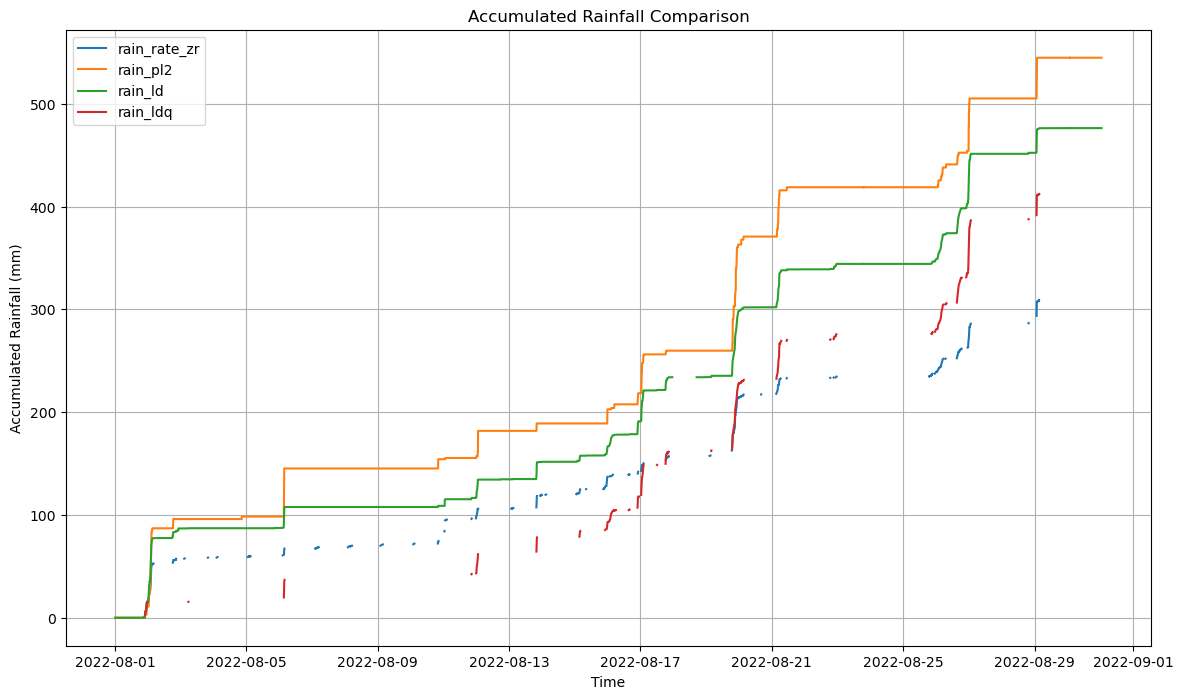

In [34]:

accumulated_columns = ['rain_rate_zr', 'rain_pl2', 'rain_ld', 'rain_ldq']
plot_accumulated_rainfall(merged_df, accumulated_columns, 'Accumulated Rainfall Comparison')



# Plot time series of rain rates


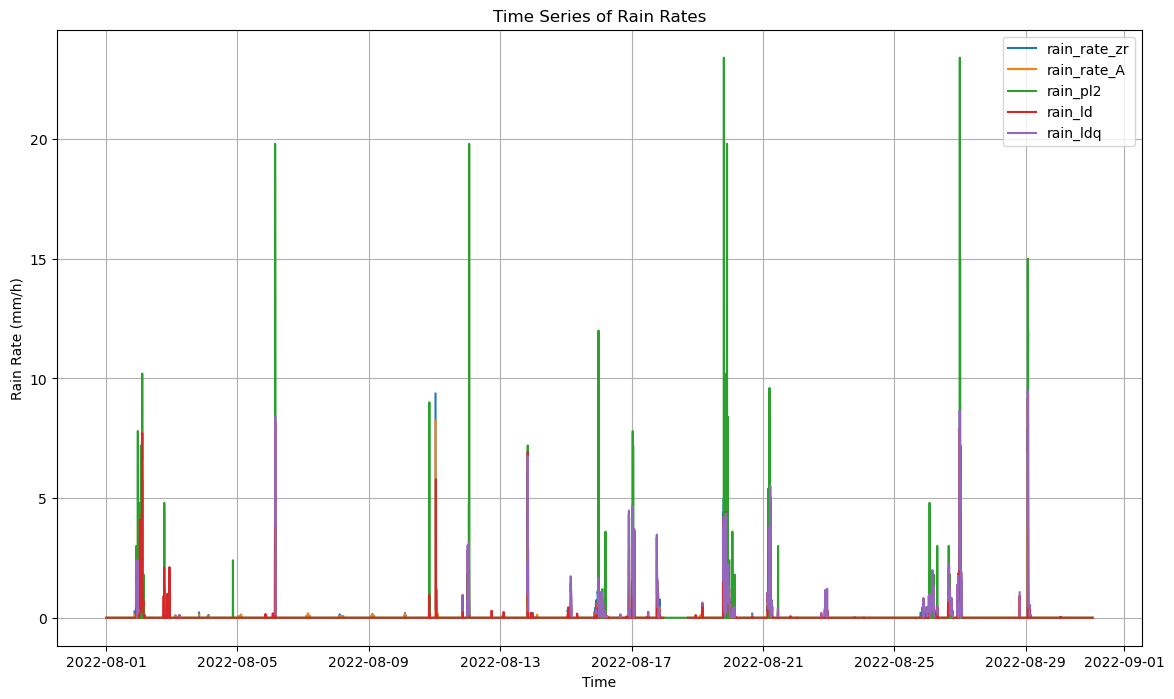

In [35]:

time_series_columns = ['rain_rate_zr', 'rain_rate_A', 'rain_pl2', 'rain_ld', 'rain_ldq']
plot_time_series(merged_df, time_series_columns, 'Time Series of Rain Rates')



# Plot histograms of rain rates


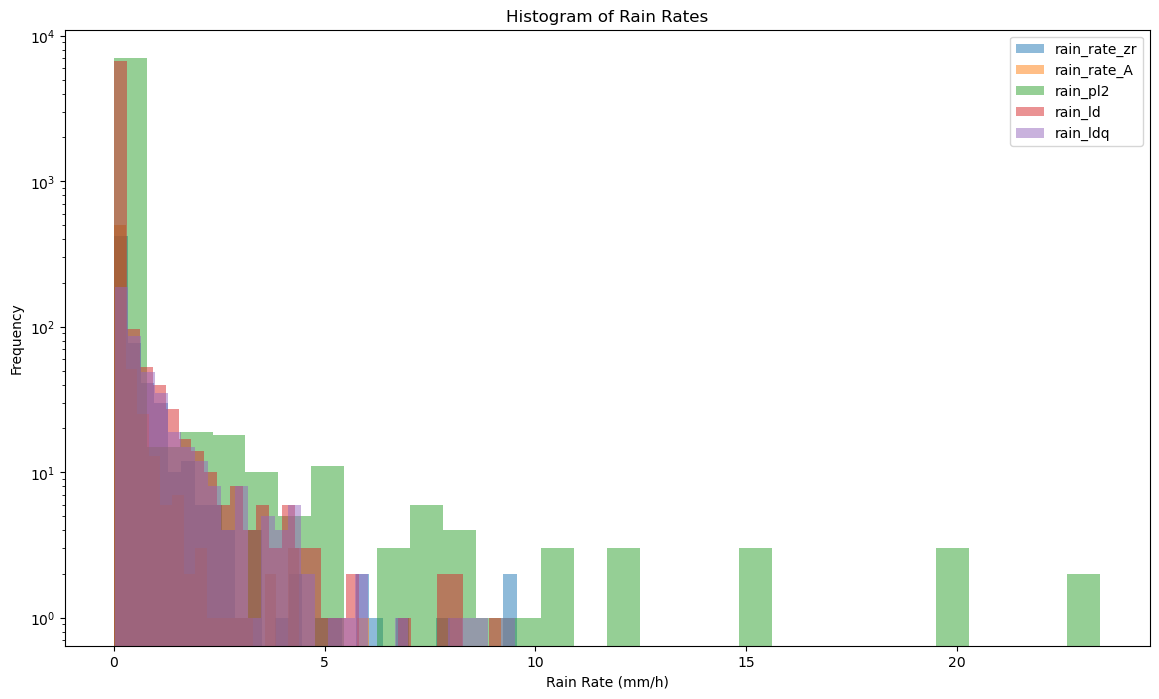

In [36]:

plot_histogram(merged_df, time_series_columns, 'Histogram of Rain Rates')


Pl2 produces higher rain rates that are missing in other data.


# Plot scatter comparisons with PL2 as truth


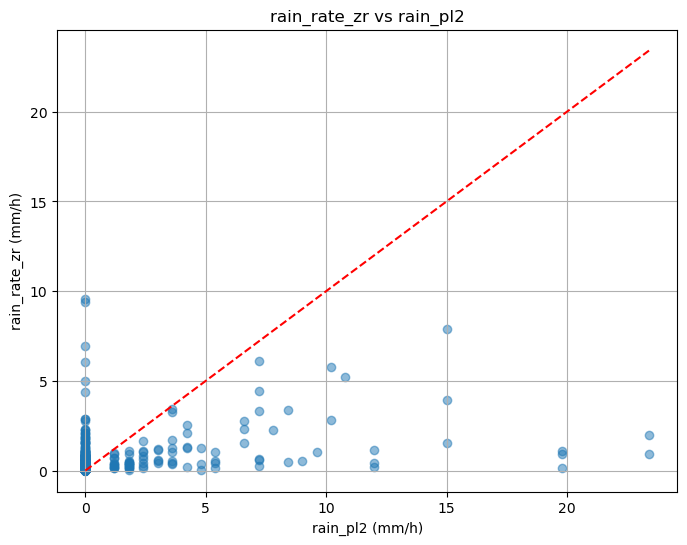

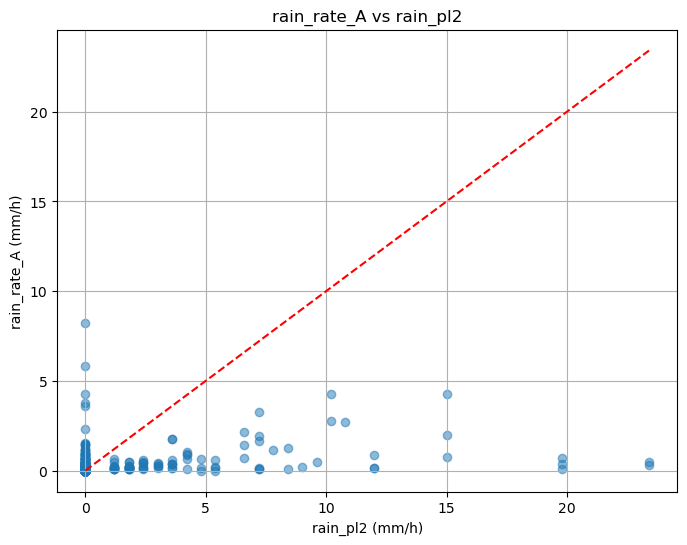

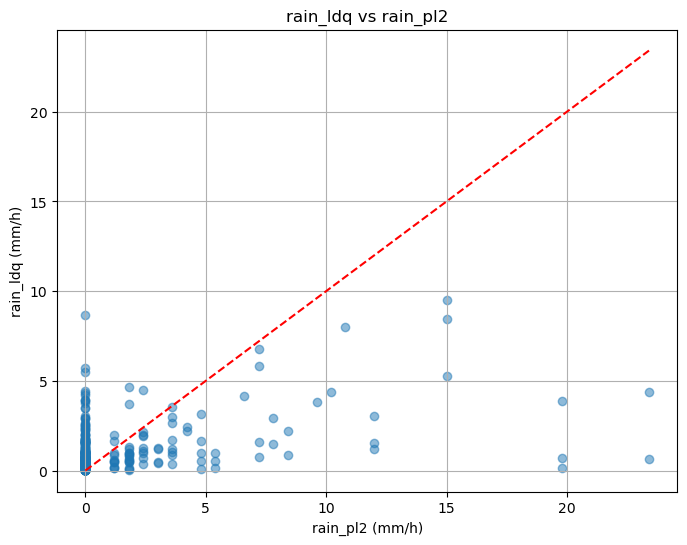

In [37]:

plot_scatter_comparison(merged_df, 'rain_pl2', estimate_cols, filename_prefix='scatter_comparison_pl2')


I suspect these scattered plot will, match better with 5 min accumulated rain instead of one minutes  as the radar rain is from swipe 0.


# Plot scatter comparisons with LD as truth


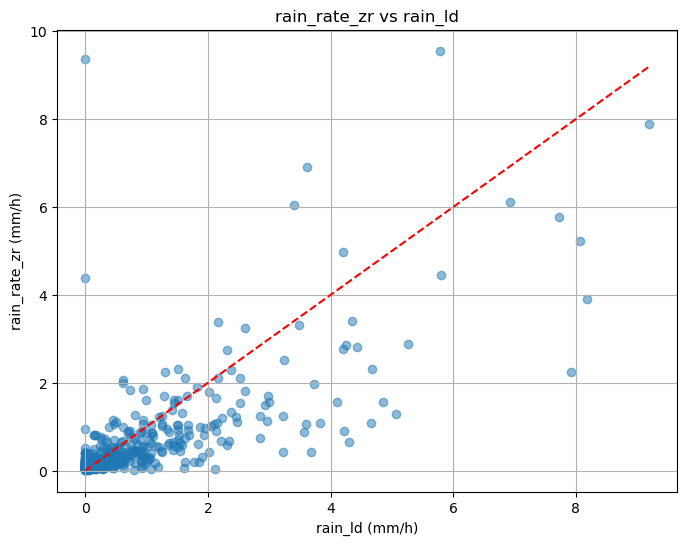

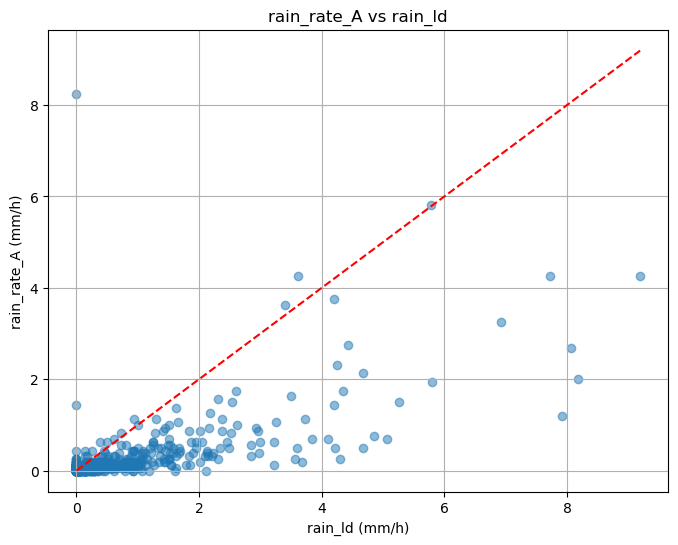

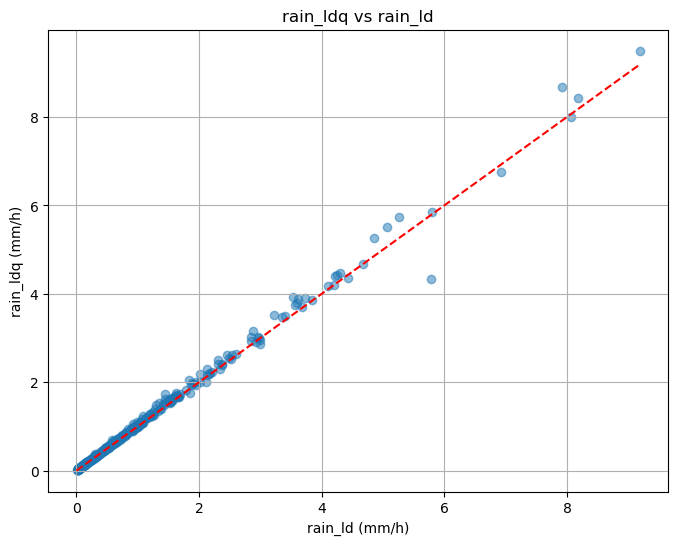

In [38]:
plot_scatter_comparison(merged_df, 'rain_ld', estimate_cols, filename_prefix='scatter_comparison_ld')